# 安然机器学习项目开放式问题

## 1. 向我们总结此项目的目标以及机器学习对于实现此目标有何帮助。作为答案的部分，提供一些数据集背景信息以及这些信息如何用于回答项目问题。你在获得数据时它们是否包含任何异常值，你是如何进行处理的？

安然曾经是2000年美国最大的公司之一。2002年，由于其存在大量的企业欺诈行为，这个昔日的大集团土崩瓦解。在随后联邦进行的调查过程中，公开了成千上万涉及高管的邮件和详细的财务数据，包括“工资”，“奖金”，“长期激励”，“发送的邮件数量”和“收到的邮件数量”等等。本次项目将使用这份公开的财务和邮件数据，通过机器学习技术构建嫌疑人识别器，找出数据中可能存在的模式，用于识别谁是有欺诈嫌疑的安然员工。

数据点的总数为145，这些数据点有两个类别：POI/非POI。原始的特征分为两类：财务特征和邮件特征。财务特征有14个，邮件特征有6个。不过某些特征有很多缺失值，比如loan_advances。

获得的财务数据存在异常值，通过对salary和bonus绘制散点图发现了一个明显过大的异常值。该异常值是由原始数据中的汇总信息造成的（“Total”），因此需要删除该异常值。删除之后对数据进行进一步检查，还能发现两个疑似的异常值点——至少5百万美元的奖金和超过1百万美元的工资，这些疑似点对应的当事人为LAY KENNETH L和SKILLING JEFFREY K，通过安然丑闻的背景信息了解到这两人就是该事件的核心人物，因此它们是有效的数据点，需要保留。

## 2. 你最终在你的 POI 标识符中使用了什么特征，你使用了什么筛选过程来挑选它们？你是否需要进行任何缩放？为什么？作为任务的一部分，你应该尝试设计自己的特征，而非使用数据集中现成的——解释你尝试创建的特征及其基本原理。在你的特征选择步骤，如果你使用了算法（如决策树），请也给出所使用特征的特征重要性；如果你使用了自动特征选择函数（如 SelectBest），请报告特征得分及你所选的参数值的原因。

根据我对原始数据集的调查和探索，我首先去除了total_payments和total_stock_value这两个特征，因为它们分别是其他一些特征的和，与一些其他已存在的特征强相关。另外对于具有很多NaN的特征我**暂时**选择了保留，因为这样的特征也许隐含了数据的某种模式。

在此基础上我创建了两个新的特征from_this_person_to_poi_ratio和from_poi_to_this_person_ratio，分别代表“当事人发给POI邮件占总发送邮件的比例”和“当事人收到POI邮件占总收到邮件的比例”。因为单纯的从当事人发给POI或收到POI邮件的数量并不一定能说明问题，而通过这样的特征缩放能看出当事人与POI来往的密切程度，缩放后的比例值越高，当事人自己就越有可能是POI。

在以上处理完成后我对特征进行了智能评估，如下所示：

In [39]:
%run poi_id.py

estimator: Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', GaussianNB(priors=None))]), f1 score: 0.330611904762

estimator: Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=4, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]), f1 score: 0.495900333

estimator: Pipeline(steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=

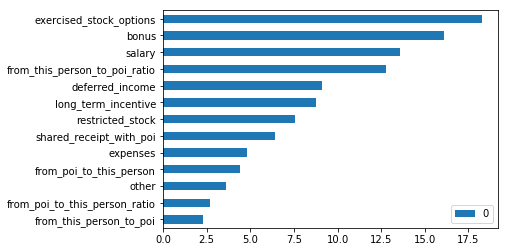

In [40]:
import operator
import pandas as pd
%matplotlib inline
selected_features = dict()
for f in features_list[1:]:
    selected_features[f] = feature_scores[f]
sorted_features = sorted(selected_features.items(), key=operator.itemgetter(1), reverse=True)
indices = []
scores = []
for t in sorted_features:
    indices.append(t[0])
    scores.append(t[1])
df = pd.DataFrame(scores, index=indices)
df.plot(kind='barh').invert_yaxis()

在“特征选择”步骤中我使用了自动特征选择函数SelectKBest来查看所有特征的评分，并最终将得分低于2.0的特征去除，某些缺失值比较多的特征也予以去除（比如“loan_advances”），其他特征均予以保留。上图为最终保留的特征和各自的得分。

## 3. 你最终使用了什么算法？你还尝试了其他什么算法？不同算法之间的模型性能有何差异？

我最终使用了支持向量机分类器算法。我还尝试了“朴素贝叶斯”，“决策树”和“基于决策树的AdaBoost”算法。我是以f1分数作为算法性能的评估标准的，其中支持向量机分类算法得分为0.496；其次是朴素贝叶斯分类器，得分为0.331；AdaBoost和决策树算法性能分别为0.26和0.235。

## 4. 调整算法的参数是什么意思，如果你不这样做会发生什么？你是如何调整特定算法的参数的？（一些算法没有需要调整的参数 – 如果你选择的算法是这种情况，指明并简要解释对于你最终未选择的模型或需要参数调整的不同模型，例如决策树分类器，你会怎么做）。

调整算法的参数是指根据具体要解决的问题选择合适的算法参数以提高分类器性能，如果不调参最后得出的分类器性能就达不到要求（f1值过低）。对于我所选择的支持向量机分类器算法，我是通过Pipeline+GridSearchCV的机制进行参数调整的。即通过Pipeline封装一系列步骤：首先进行标准特征缩放（SVM算法要求对特征进行缩放）和PCA；然后向GridSearchCV的param_grid参数传递参数C，kernel，class_weight和gamma等参数值的不同组合；最后由GridSearchCV给出最佳的参数组合即可。

## 5. 什么是验证，未正确执行情况下的典型错误是什么？你是如何验证你的分析的？

验证是指将数据分为训练集和测试集两个部分，通过训练集拟合模型，然后用测试集验证算法的性能。如果没有正确执行验证，那么得到的算法模型可能是过拟合的——对未知情况适应性非常差。

我通过三个度量指标来对每个分类器算法性能进行评估：f1分数，精确度和召回率。我首先将待评估的算法分别用GridSearchCV进行封装，然后迭代地对每个分类器算法进行拟合（GridSearchCV会自动执行交叉验证过程），然后我通过estimate_classifier()函数对拟合过后的分类器计算f1分数，最后选择f1分数最高的“最优参数+最优算法模型”作为最终的clf。

estimate_classifier()函数的原理：首先通过StratifiedShuffleSplit将数据分为若干训练集和测试集，然后对算法模型进行拟合，调用sklearn.metrics.f1_score计算每次的f1分数，最后返回f1分数的平均值。

## 6. 给出至少 2 个评估度量并说明每个的平均性能。解释对用简单的语言表明算法性能的度量的解读。

对我所选择的支持向量机分类器而言，最优参数为C=1.0，class_weight='balanced'，kernel='sigmoid'和gamma=0.10000000000000001，PCA的n_components参数为4。精确度0.331，即被判定为POI的样本中有33.1%为真正的POI；召回率0.862，即所有的POI中有86.2%被正确的分类；f1分数为0.479，为精确度和准确率的加权调和平均值。